# Evaluate final performances from different runs

In [1]:
from gymnasium.experimental.wrappers import RecordVideoV0
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

import _pickle as pickle
import jax
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

from jaxl.buffers import get_buffer
from jaxl.constants import *
from jaxl.models import (
    get_model,
    get_policy,
    policy_output_dim,
)
from jaxl.models.policies import MultitaskPolicy
from jaxl.envs import get_environment
from jaxl.envs.rollouts import EvaluationRollout
from jaxl.utils import (
    set_seed,
    parse_dict,
    set_dict_value,
    get_dict_value,
    RunningMeanStd,
)

In [2]:
run_seed = None
set_seed(run_seed)

In [3]:
def get_env(agent_path):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
    return agent_config_dict["learner_config"]["env_config"]

In [4]:
# agent_path = "/Users/chanb/research/personal/jaxl/data/hyperparam_search/hopper_cont/search_expert/runs/1/variant-138/07-12-23_16_41_59-34de64b8-6a08-4292-88c9-fe12358710d7"
# runs_dir = "/Users/chanb/research/personal/jaxl/data/hyperparam_search/hopper_cont/search_expert/runs"

# agent_path = "/Users/chanb/research/personal/jaxl/data/hyperparam_search/hopper_disc/search_expert/runs/0/variant-14/07-12-23_16_20_52-884602c9-a9b9-4844-9d08-7fb71bc08abf"
# runs_dir = "/Users/chanb/research/personal/jaxl/data/hyperparam_search/hopper_disc/search_expert/runs"

# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/pendulum/discrete/runs/0/variant-20/07-19-23_09_45_28-3f727c34-d48c-426c-b8c9-b1f39a43997a"
# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/pendulum/continuous/runs/0/variant-68/07-19-23_09_34_42-e626f409-3ee3-4f7e-a86c-1f3aeefd876f"
# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/cheetah/discrete/runs/0/variant-71/07-19-23_08_19_57-c49d4632-446b-401c-8d5a-05805f605f93"
# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/cheetah/continuous/runs/0/variant-46/07-19-23_07_45_39-8cee976a-eeea-4423-b49b-2b8c154bf9c2"

# Walker run
# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/walker-run/discrete/runs/0/variant-19/07-19-23_08_51_26-ad429b0c-ac8c-4e5d-b54c-954ff04a8326"
# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/walker-run/continuous/runs/0/variant-43/07-19-23_08_34_12-233bdacb-b391-45a8-abd3-b4302793c811"

# Walker walk
# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/walker/discrete/runs/0/variant-23/07-20-23_00_17_47-83e8809d-83d1-4469-89ff-9568df858294"
# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/data/search_expert/walker/continuous/runs/0/variant-10/07-19-23_23_48_24-f58e40b4-a9c6-44bc-b0e6-3ce4e6eaacfb"

# agent_path = runs_dir = "/Users/chanb/research/personal/mtil_results/preliminary/all_sweep-single_seed-single_env_seed/walker/continuous/runs/0/variant-10/07-19-23_23_48_24-f58e40b4-a9c6-44bc-b0e6-3ce4e6eaacfb"
agent_path = (
    runs_dir
) = "/Users/chanb/research/personal/jaxl/jaxl/logs/pendulum_discrete/ppo-same_hyper/07-29-23_12_31_33-0e9cdf80-41eb-4565-a393-9d2ac1d9d15c"
trained_env_parameters = get_env(agent_path)


num_episodes = 100
env_seed = 9999
buffer_size = 0
record_video = True

In [5]:
def get_config(agent_path):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
        agent_config_dict["learner_config"]["env_config"] = trained_env_parameters
        agent_config_dict["learner_config"]["env_config"]["env_kwargs"][
            "render_mode"
        ] = "rgb_array"
        if "policy_distribution" not in agent_config_dict["learner_config"]:
            agent_config_dict["learner_config"][
                "policy_distribution"
            ] = CONST_DETERMINISTIC
        set_dict_value(agent_config_dict, "vmap_all", False)
        (multitask, num_models) = get_dict_value(agent_config_dict, "num_models")
        agent_config = parse_dict(agent_config_dict)
    return agent_config, {
        "multitask": multitask,
        "num_models": num_models,
    }

In [6]:
# Build agent and policy
agent_config, aux = get_config(agent_path)
env = get_environment(agent_config.learner_config.env_config)

input_dim = env.observation_space.shape
output_dim = policy_output_dim(env.act_dim, agent_config.learner_config)
model = get_model(
    input_dim,
    output_dim,
    getattr(agent_config.model_config, "policy", agent_config.model_config),
)
policy = get_policy(model, agent_config.learner_config)
if aux["multitask"]:
    policy = MultitaskPolicy(policy, model, aux["num_models"])

In [7]:
episodic_returns_per_variant = {}

for run_path, _, filenames in os.walk(runs_dir):
    for filename in filenames:
        if filename != "config.json":
            continue
        agent_path = run_path

        variant = os.path.basename(os.path.dirname(agent_path))

        model_id = f"{variant}-final"
        if record_video:
            env = RecordVideoV0(
                env,
                f"videos/eval_final/model_id_{model_id}-videos",
                disable_logger=True,
            )

        checkpoint_manager = CheckpointManager(
            os.path.join(agent_path, "models"),
            PyTreeCheckpointer(),
        )
        params = checkpoint_manager.restore(checkpoint_manager.latest_step())
        model_dict = params[CONST_MODEL_DICT]
        agent_policy_params = model_dict[CONST_MODEL][CONST_POLICY]
        agent_obs_rms = False
        if CONST_OBS_RMS in params:
            agent_obs_rms = RunningMeanStd()
            agent_obs_rms.set_state(params[CONST_OBS_RMS])

        agent_rollout = EvaluationRollout(env, seed=env_seed)
        agent_rollout.rollout(
            agent_policy_params, policy, agent_obs_rms, num_episodes, None
        )

        episodic_returns_per_variant[model_id] = agent_rollout.episodic_returns

100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


In [8]:
if hasattr(env, "get_config"):
    print(env.get_config())

{'modified_attributes': {'max_torque': 2.0}}


In [9]:
from pprint import pprint

pprint(
    [
        (key, np.mean(val), np.std(val))
        for key, val in episodic_returns_per_variant.items()
    ]
)

[('ppo-same_hyper-final', -183.0344760375588, 101.84499767370693)]


[-183.03447604] [101.84499767]


/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_69951/2015625105.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


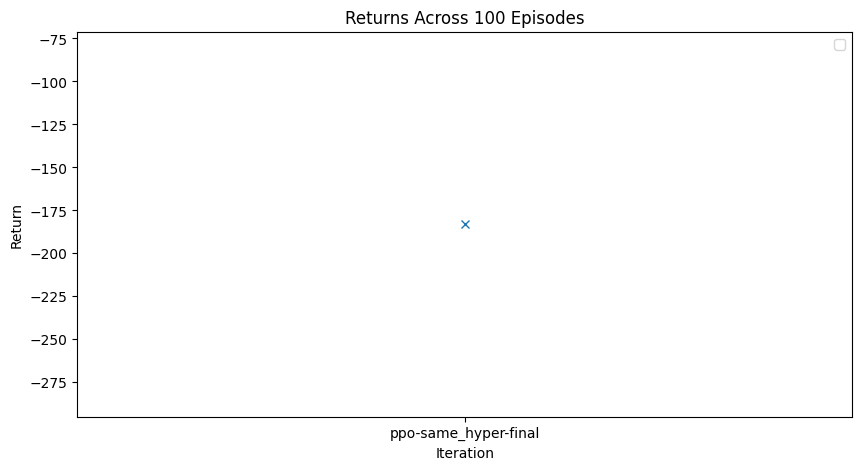

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 5))

model_ids = list(episodic_returns_per_variant.keys())
means = []
stds = []
for val in episodic_returns_per_variant.values():
    means.append(np.mean(val))
    stds.append(np.std(val))
means = np.array(means)
stds = np.array(stds)

print(means, stds)
sort_idxes = np.argsort(model_ids)
model_ids = np.array(model_ids)
ax.plot(model_ids[sort_idxes], means[sort_idxes], marker="x")
ax.fill_between(
    model_ids[sort_idxes],
    means[sort_idxes] + stds[sort_idxes],
    means[sort_idxes] - stds[sort_idxes],
    alpha=0.1,
)
ax.set_title(f"Returns Across {num_episodes} Episodes")
ax.set_xlabel("Iteration")
ax.set_ylabel("Return")
ax.legend()
fig.show()